In [1]:
import os
import pathlib
import time
import datetime
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt

In [2]:
PATH = "/Users/viralthakar/Documents/code/Git/awesome-ml-for-uiux/icon-generation/data/dataset-images"
TRAIN_PATH = "/Users/viralthakar/Documents/code/Git/awesome-ml-for-uiux/icon-generation/data/dataset-images/train"
TEST_PATH = "/Users/viralthakar/Documents/code/Git/awesome-ml-for-uiux/icon-generation/data/dataset-images/test"


In [3]:
sample_image = tf.io.read_file(os.path.join(TRAIN_PATH, "26.png"))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(32, 64, 1)


2022-11-30 11:31:52.572186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 11:31:52.572311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


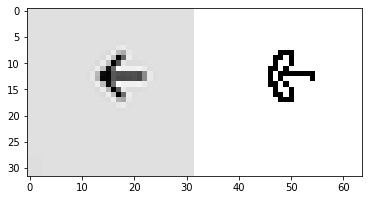

In [4]:
plt.figure()
plt.imshow(sample_image, cmap='gray')

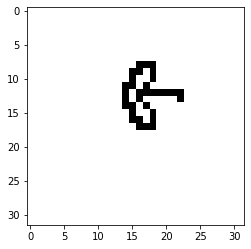

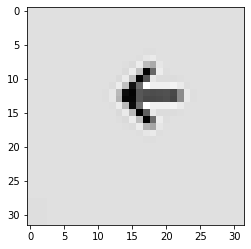

In [5]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image


inp, re = load(os.path.join(TRAIN_PATH, "26.png"))
plt.figure()
plt.imshow(inp / 255.0, cmap="gray", vmin=0.0, vmax=1.0)

plt.figure()
plt.imshow(re / 255.0, cmap="gray", vmin=0.0, vmax=1.0)


In [6]:
BUFFER_SIZE = 6785
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1


In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image, height=256, width=256):
  input_image, real_image = resize(input_image, real_image, height, width)
  return input_image, real_image

In [10]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [11]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image


In [12]:
train_dataset = tf.data.Dataset.list_files(os.path.join(TRAIN_PATH, "*.png"))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [13]:
test_dataset = tf.data.Dataset.list_files(os.path.join(TEST_PATH, "*.png"))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [15]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [16]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
      downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
      downsample(128, 4),  # (batch_size, 64, 64, 128)
      downsample(256, 4),  # (batch_size, 32, 32, 256)
      downsample(512, 4),  # (batch_size, 16, 16, 512)
      downsample(512, 4),  # (batch_size, 8, 8, 512)
      downsample(512, 4),  # (batch_size, 4, 4, 512)
      downsample(512, 4),  # (batch_size, 2, 2, 512)
      downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
      upsample(512, 4),  # (batch_size, 16, 16, 1024)
      upsample(256, 4),  # (batch_size, 32, 32, 512)
      upsample(128, 4),  # (batch_size, 64, 64, 256)
      upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

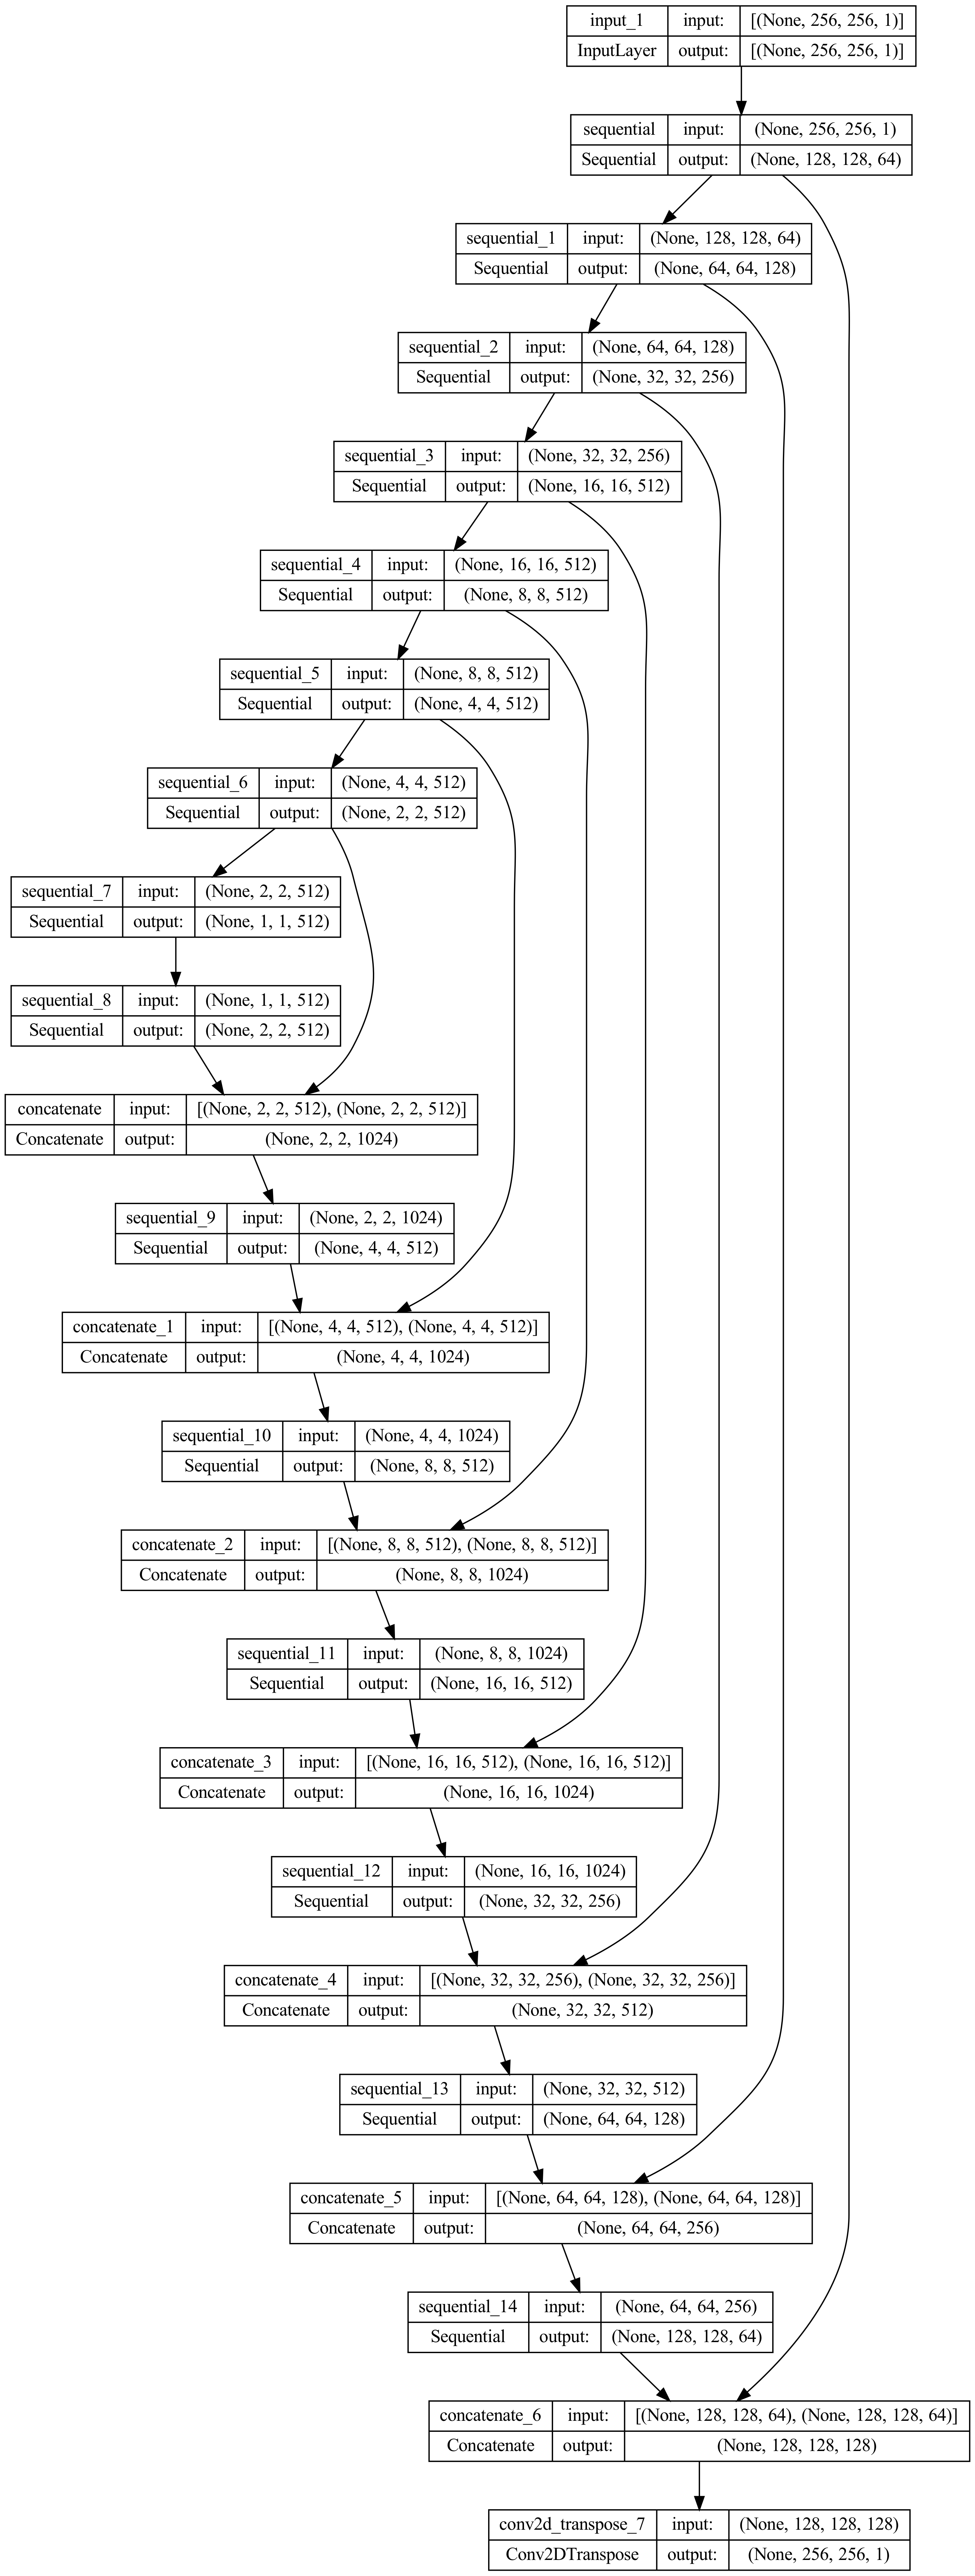

In [17]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=300)

In [18]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [19]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(
      disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


In [20]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  # (batch_size, 256, 256, channels*2)
  x = tf.keras.layers.concatenate([inp, tar])

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(
      leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


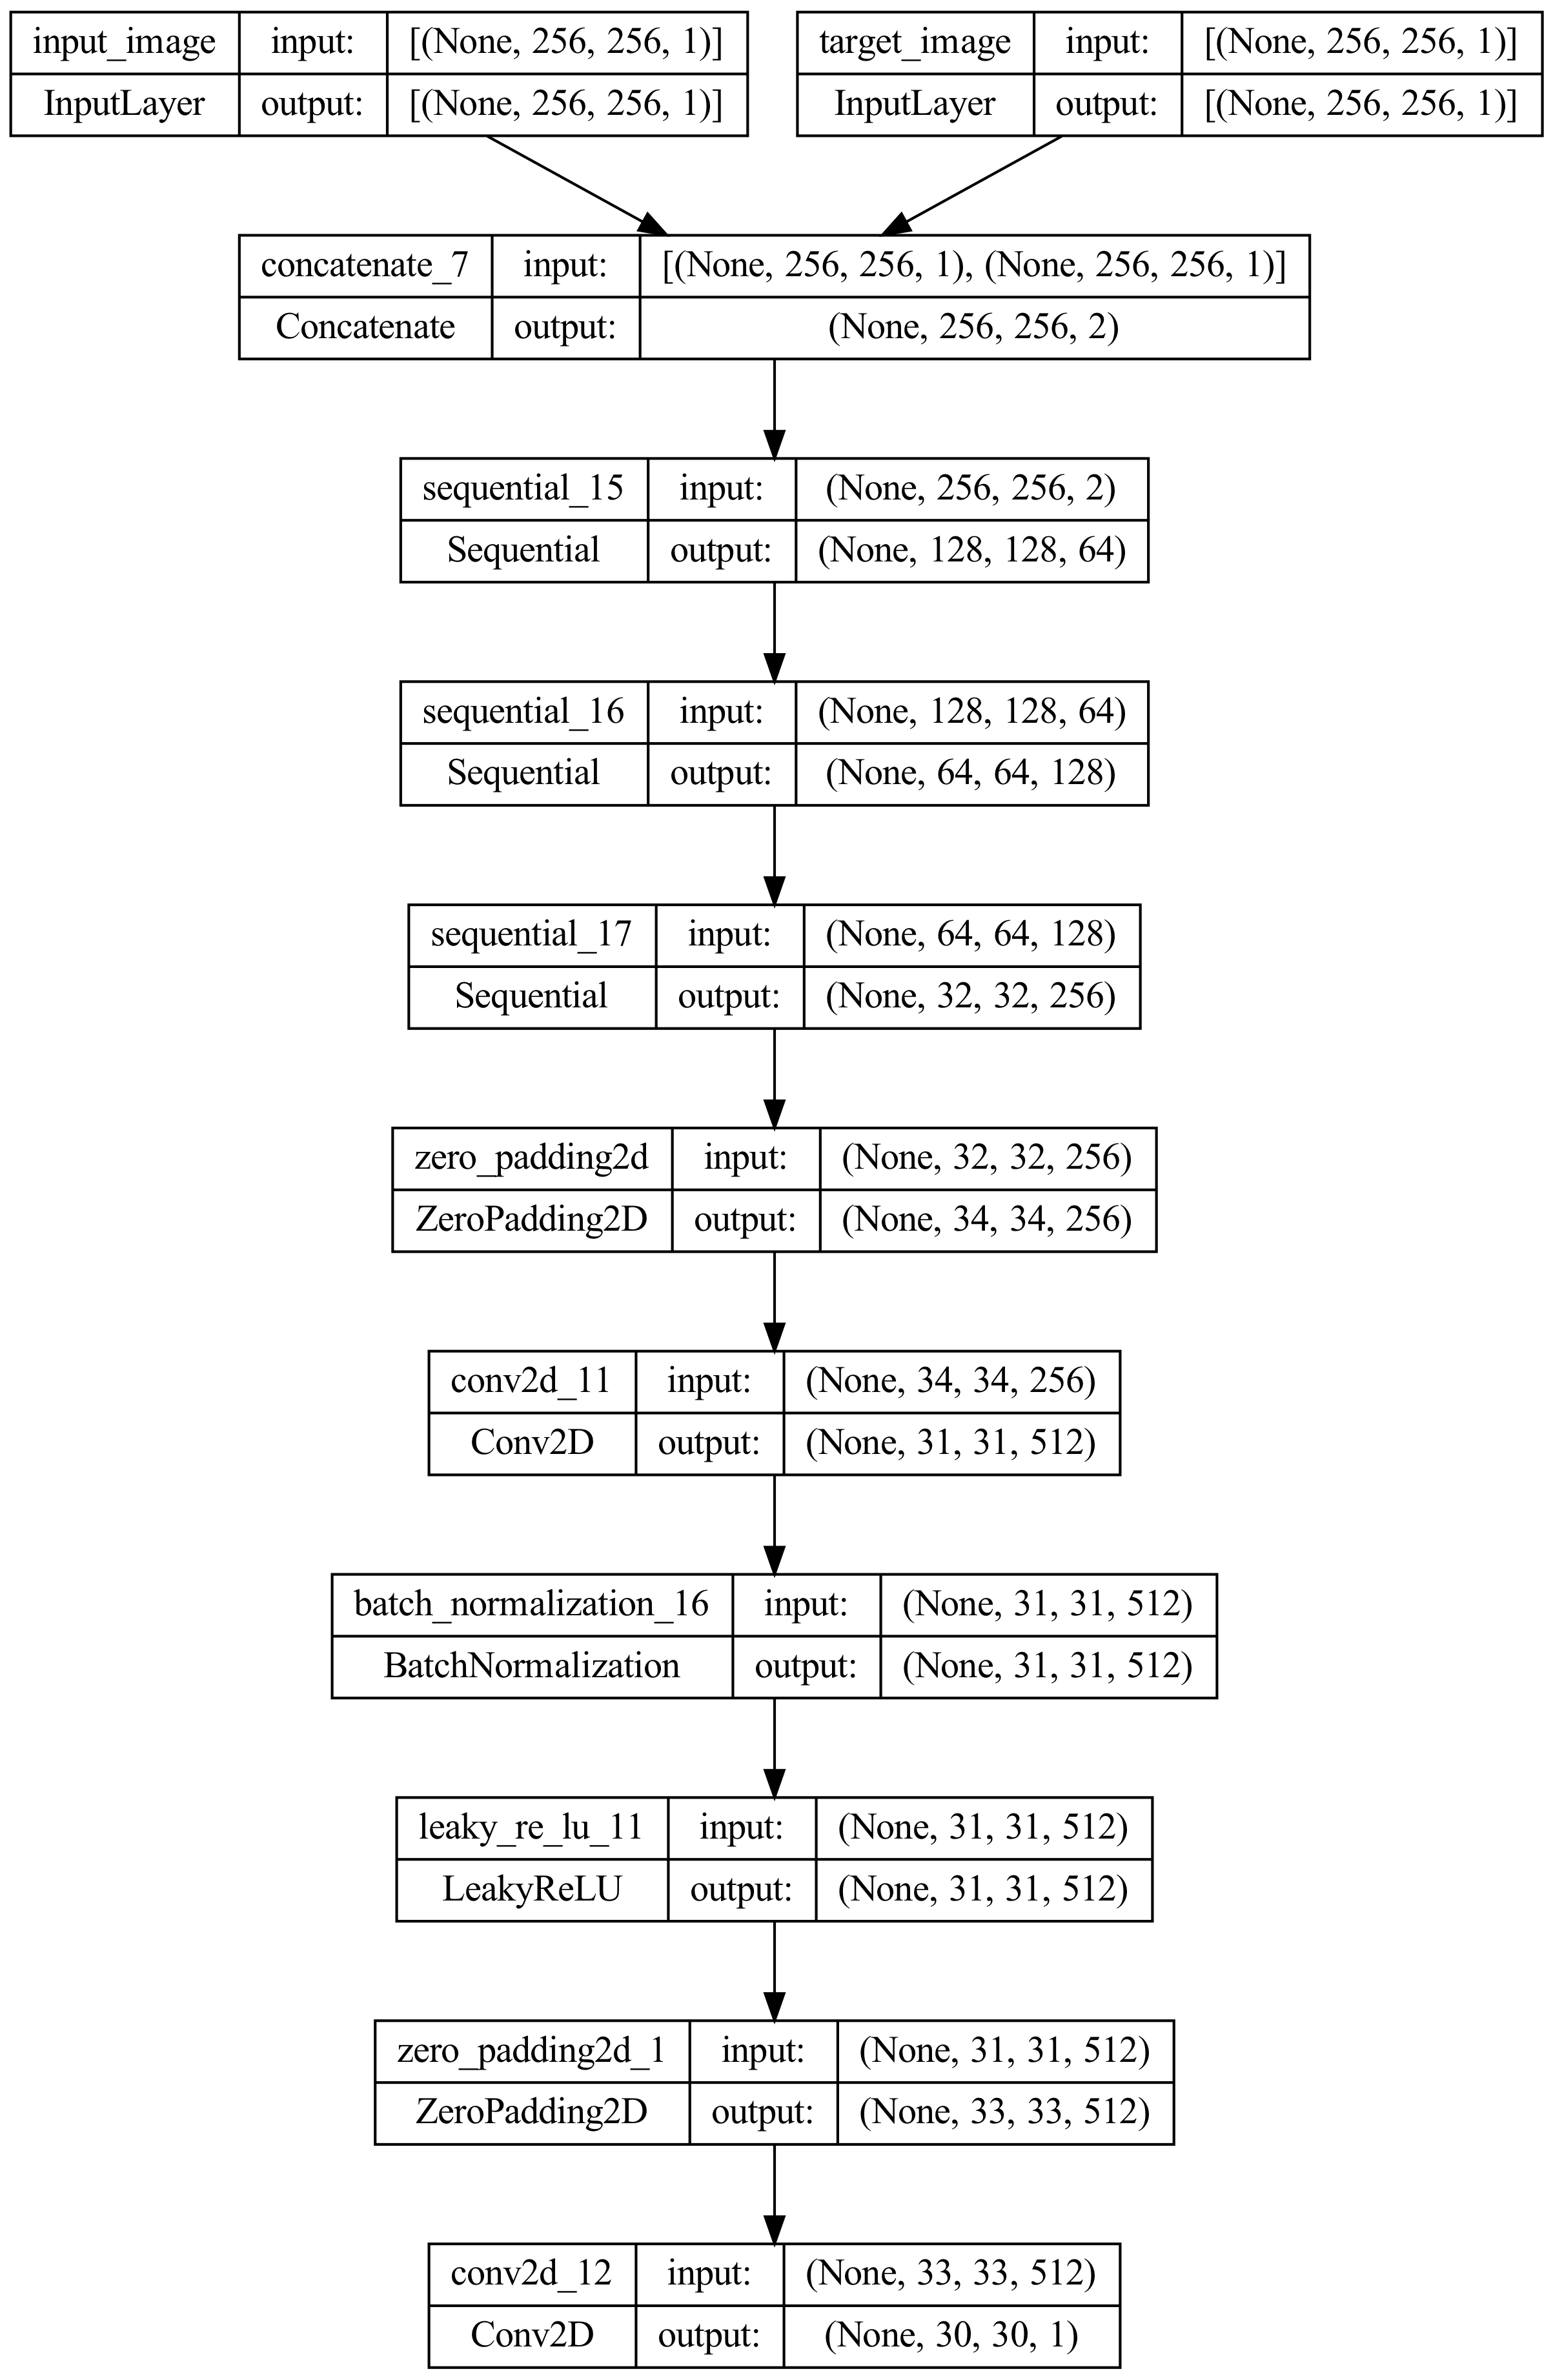

In [21]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=300)

In [22]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(
      disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
checkpoint_dir = '/Users/viralthakar/Documents/code/Git/awesome-ml-for-uiux/icon-generation/artifacts/arrows/training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
  plt.show()

In [26]:
log_dir = "/Users/viralthakar/Documents/code/Git/awesome-ml-for-uiux/icon-generation/artifacts/arrows/logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator(
        [input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
        disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [28]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()
      
      example_input, example_target = next(iter(test_ds.take(1)))
      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 1000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


In [29]:
# fit(train_dataset, test_dataset, steps=40000)

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [31]:
pp = "/Users/viralthakar/Documents/code/Git/awesome-ml-for-uiux/icon-generation/artifacts/inference"
def inference_images(model, test_input, tar, path, count=0):
  prediction = model(test_input, training=False)
  os.makedirs(os.path.join(path, "input-images"), exist_ok=True)
  os.makedirs(os.path.join(path, "output-images"), exist_ok=True)
  os.makedirs(os.path.join(path, "gt-images"), exist_ok=True)
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  plt.imshow((test_input[0] * 0.5 + 0.5)*255, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.savefig(os.path.join(path, "input-images", f"{str(count)}.jpg"))
  plt.close(fig)
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  plt.imshow((prediction[0] * 0.5 + 0.5)*255, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.savefig(os.path.join(path, "output-images", f"{str(count)}.jpg"))
  plt.close(fig)
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  plt.imshow((tar[0] * 0.5 + 0.5)*255, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.savefig(os.path.join(path, "gt-images", f"{str(count)}.jpg"))
  plt.close(fig)


In [32]:
count = 0
for inp, tar in test_dataset.take(730):
  inference_images(generator, inp, tar, pp, count)
  count = count + 1


2022-11-30 11:31:58.970970: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
